In [1]:
result_dir = "output_weak_baselines"

In [28]:
datasets = [
    "agnews",
    "bank-marketing",
    "basketball",
    "bioresponse",
    "census",
    "commercial",
    "imdb",
    "mushroom",
    "phishing",
    "sms",
    "spambase",
    "tennis",
    "trec",
    "yelp",
    "yoruba",
    "youtube",
    "hausa",
    "imdb136",
    "amazon",
    "professor_teacher",
]

In [29]:
import os
import pandas as pd
import numpy as np

methods = os.listdir(result_dir)
# methods = filter(lambda method: (method != "sgb_aum") and (method != "sgb_forget") and (method != "gold"), methods)
results = []
for method in methods:
    for dataset in datasets:
        with open(os.path.join(result_dir, method, f"{dataset}.json")) as f:
            results.append(pd.read_json(f, orient="index").transpose())

results = pd.concat(results)

In [30]:
results["class_ratio"] = results["class_distribution"].apply(min) / results[
    "class_distribution"
].apply(max)

results["noisy_class_ratio"] = results["noisy_class_distribution"].apply(min) / results[
    "noisy_class_distribution"
].apply(max)

results["classes"] = np.where(
    results["class_distribution"].map(lambda d: len(d)) > 2,
    "multiclass",
    "binary",
)

results["accuracy"] = results["accuracy"].astype(float)
results["balanced_accuracy"] = results["balanced_accuracy"].astype(float)
results["log_loss"] = results["log_loss"].astype(float)

In [31]:
detectors = results["detector_name"].unique().tolist()
datasets = results["dataset_name"].unique().tolist()

In [32]:
table = results.pivot(
    index="dataset_name",
    columns="detector_name",
    values="balanced_accuracy",
)
# table.loc["mean"] = table.mean()
# table.loc["median"] = table.median()
table = table.round(4)*100

table.to_latex("table.tex")
table

detector_name,gold,none,silver,wood
dataset_name,,,,
agnews,86.74,69.88,75.25,70.97
amazon,92.61,61.45,74.21,70.55
bank-marketing,69.47,78.38,79.42,75.97
basketball,81.60,46.63,73.48,46.63
bioresponse,77.18,57.98,63.56,57.45
census,77.42,58.65,65.62,58.28
commercial,92.71,92.19,92.91,92.19
hausa,71.34,38.85,40.22,38.94
imdb,85.04,72.16,72.80,71.20


In [33]:
(-table).rank(axis=1)

detector_name,gold,none,silver,wood
dataset_name,,,,
agnews,1.0,4.0,2.0,3.0
amazon,1.0,4.0,2.0,3.0
bank-marketing,4.0,2.0,1.0,3.0
basketball,1.0,3.5,2.0,3.5
bioresponse,1.0,3.0,2.0,4.0
census,1.0,3.0,2.0,4.0
commercial,2.0,3.5,1.0,3.5
hausa,1.0,4.0,2.0,3.0
imdb,1.0,3.0,2.0,4.0


In [34]:
from critdd import Diagram
from itertools import starmap

diagram = Diagram(
    table.to_numpy(),
    treatment_names=list(
        starmap(
            lambda column, perf: f"{column} {round(perf,2)}",
            zip(table.columns, table.median()),
        )
    ),
    maximize_outcome=True,
)
diagram.to_file("critdd.pdf")

/home/fgmc9692/.local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


/home/fgmc9692/.local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


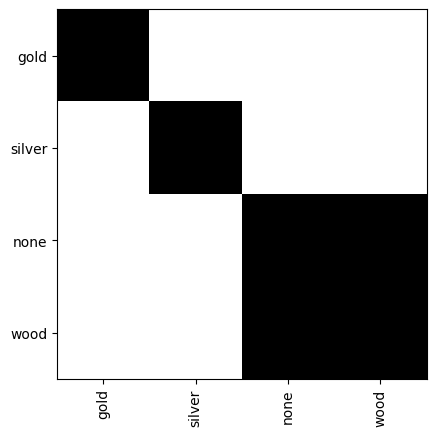

In [35]:
from itertools import product
from scipy.stats import wilcoxon, rankdata
import matplotlib.pyplot as plt

names = np.asarray(sorted(results["detector_name"].unique()))
competitors = (
    results.groupby("detector_name", sort="dataset_name")["balanced_accuracy"]
    .agg(list)
    .map(np.array)
    .tolist()
)
competitors = np.asarray(competitors)
avg_ranks = np.mean(rankdata(competitors, axis=0), axis=1)
order = np.flip(np.argsort(avg_ranks))
competitors = competitors[order]
names = names[order]
n_competitors = len(competitors)
matrix = np.empty((n_competitors, n_competitors), dtype=bool)
for (i1, c1), (i2, c2) in product(enumerate(competitors), repeat=2):
    if not np.all(np.equal(c1, c2)):
        s, p = wilcoxon(c1, c2)
        matrix[i1, i2] = p < 0.05
    else:
        matrix[i1, i2] = False
plt.imshow(~matrix, cmap="Greys")
plt.xticks(range(n_competitors), names, rotation="vertical")
plt.yticks(range(n_competitors), names)
plt.savefig("wilcoxon.pdf", bbox_inches='tight')

In [ ]:
# rajouter plot performance finale vs qualité du ranking

# est-ce que les detecteurs qui filtrent plus sont meilleurs ?

# est-ce que tuner le threshold d'agra reduit ses perfs ?

# relancer le bench en annexe avec modele final en model final

# sanity check : detector avec trust_scores random

# les trois points clés
# - ranking quality décorélé de la perf finale
# - y a toujours des approches meilleures que none mais différent selon le type de bruit => difficulté à trouver un champion car le type de bruit de la vrai vie est incconu
# - grosse limite du bench : jeu de validation clean nécessaire : (plot sms avec validation noisy + bench validation noisy) à comparer à du biquality (bonus algo biquality lancé sur le bench)
# - amélioration d'agra sur le ncar